In [1]:
from matplotlib import pyplot as plt
import math
import numpy as np
from tqdm import tqdm
import random
import seaborn as sns
import random

In [2]:
class Brownian():
    def __init__(self, s0) -> None:
        self.s0 = s0

    def stock_price(
        self,
        mu_fn = lambda x: 1,
        sigma_fn = lambda x: 1,
        deltaT = 52,
        dt = 0.1):
        
        # for n time steps
        n_timesteps = int(deltaT/dt)

        # np array of values
        S = np.zeros(n_timesteps+1)
        # Set first timestep to s0
        S[0] = self.s0

        # Generate sigma and mu vectors
        # range between 0,1 incremented by n_timesteps
        mu_vec = np.array([mu_fn(x/n_timesteps) for x in range(n_timesteps)])
        sigma_vec = np.array([sigma_fn(x/n_timesteps) for x in range(n_timesteps)])

        for t in range(n_timesteps):
            # generate noise 

            # get prev time step (s0 is index 0)
            s = S[t]
            mu = mu_vec[t]
            sig = sigma_vec[t]

            dW = np.random.normal(0,math.sqrt(dt))
            ds = mu*dt*s + sig*s*dW
            S[t+1] = s + ds
        
        # Return vals, not including s0
        return S

In [3]:
class Drift(Brownian):
    def __init__(self, deltaT, dt, s0, musig) -> None:
        """
        Params:
        dT - Duration, for plug and play with BSE
        metadata - Metadata for the drift
        stock price generates GBM with drift using 
        functions defined below.
        """
        
        # Get the total number of time steps
        super().__init__(s0=s0)
        self.n_steps = int(deltaT/dt)

        self.gbm_offset_vec = self.stock_price(deltaT=deltaT,dt=dt,mu_fn=musig.mu,sigma_fn=musig.sig)
        
    def dump_offset(self, path):
        np.save(path, np.array(self.gbm_offset_vec))

    def offset_fn(self, t):
        """
        Returns the offset 
        """
        try:
            offset = self.gbm_offset_vec[math.floor(t/self.dt)]
            return int(round(offset, 0))
        except:
            # If time IDX is clipped return the last value at the end
            print('WARNING: schedule offset clipped')
            return int(round(self.gbm_offset_vec[-1],0))

100%|██████████| 10/10 [00:00<00:00, 90.82it/s]


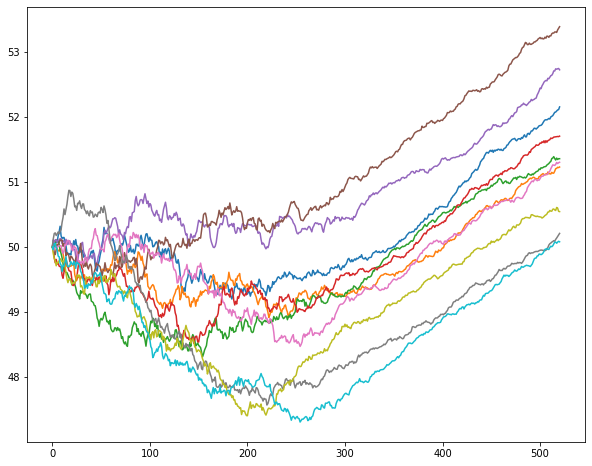

(5.146917360584457, 15.444069105959802)

In [5]:
class MuSigma:
    """
    Problems:
    Drift parameters are not normalised for the time scale, this means
    it can only be used for tested time frames
    """
    def __init__(self):
        self.meta_data = {
            'drift_type': 'gradual',
            'drift_times': [0.30, 0.65],
            'params_varied': ['mu','sigma'],
        }

    def mu(t):
        x1 = -0.0015
        x2 = 0.0020
        t1 = 0.3
        t2 = 0.65

        if t < t1:
            return x1
        elif t1 <= t <= t2:
            # Linear Increase
            m = (((x2-x1)/(t2-t1))*(t-t1))+x1
            return m
        else:
            return x2

    def sig(t):
        x1 = 0.0040
        x2 = 0.0010
        t1 = 0.3
        t2 = 0.65

        if t < t1:
            return x1
        elif t1 <= t <= t2:
            # Linear increase
            m = (((x2-x1)/(t2-t1))*(t-t1))+x1
            return m
        else:
            return x2


ep = np.zeros(100)
fig,ax = plt.subplots(figsize=(10,8))
for i in tqdm(range(10)):
    pcx = Drift(musig=MuSigma, s0=50, deltaT=52, dt=0.1).gbm_offset_vec
    plt.plot(pcx)
    ep[i] = pcx[-1]
    
plt.show()
fig.savefig('./fig.png',dpi=300.0)
np.mean(ep), np.std(ep)

Using pickle may not be appropriate

Instead, create python scripts containing classes

Easier to maintain as well

Can pickle in BSE for passing around CPUs

Perhaps drift generation could be automated??

(nan, nan)

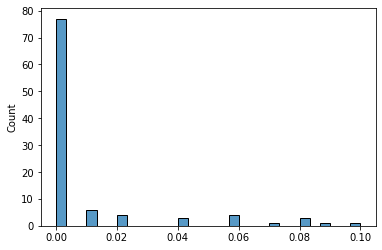

In [13]:
"""
For each window, run a monte carlo simulation under assumptions of mu and sigma
Can test if second window is 95% outside of distrbution.
"""
# Use KL distance (relative entropy) to measure similarity between windows
class BaseDrift:
    def __init__(self) -> None:
        pass

    def add_element(self):
        pass

    def drift_alarm(self):
        # Drift alarm
        pass

    def drift_detected(self):
        # Drift detection
        pass

class KLAdwin(BaseDrift):
    """
    Sliding window. When drift has been detected, data from the previous
    window is removed.

    Ideas/notes:
    Can use the window for a new ml algo.
    Bootstrap data from windows?
    Confidence level alpha from KL distance - VIA BOOTSTRAP
    If KL distance is increasing between windows at a parametric rate then gradual drift may be occuring
    
    Need to bin data somehow so bins are comparible NO
    https://www.youtube.com/watch?v=Kho4VuKmQdE
    Monte carlo simulation under 
    """
    def __init__(self, 
        alpha = 0.05, 
        window_size = 0.002, 
        n_bootstrap = 1000, 
        max_window_size = 500,
        min_window_size = 50,
        n_bins = 100,
        min_subwindow_size = 20,) -> None:
        """
        Parameters
        Alpha: Alpha for generating confidence intervals
        n_bootstrap: Number of bootstrap samples to be drawn from each dist
        max_window_size: Limit the window size
        min_window_size: Ensure window size is small enough for bootstrap (should this be calculated??)
        n_bins: number of bins when generating probability distributions
        min_subwindow_size: min size for ADWIN subwindow (again, should this be calculated??)
        """
        self.alpha = alpha
        self.n_bootstrap = n_bootstrap
        self.n_bins = n_bins
        self.delta = window_size    
        self.max_window_size = max_window_size 
        self.min_window_size = min_window_size   
        self.min_subwindow_size = min_subwindow_size    
        
        self.window_size = 0
        self.t_index = 0
        self.window = []

    @staticmethod
    def generate_pdists(n_bins, dist0:list, dist1:list):
        """
        Arguments: 
        bootstraped data from dist 0 and dist 1 : list(s)

        Returns: Two probabilty distrbutions that have the same bins
        for KL distance calculations : list(s)
        """
        def generate_dist(n_bins, bin_width, dist, min_val):
            # For every data point, add to bin
            binned = np.zeros(n_bins)
            for i in dist:
                r = i%bin_width
                bin_index = int((i-r-min_val)/bin_width)-1
                binned[bin_index] += 1
            # Div by total number to get prob dist
            total_n = np.sum(binned)
            prob_dist = binned/total_n
            return prob_dist

        all_vals = dist0 + dist1
        
        # Get max and min from all vals
        max_val = max(all_vals)
        min_val = min(all_vals)

        bin_width = (max_val-min_val)/(n_bins)

        p_dist0 = generate_dist(n_bins=n_bins, bin_width=bin_width, dist=dist0, min_val=min_val)
        p_dist1 = generate_dist(n_bins=n_bins, bin_width=bin_width, dist=dist1, min_val=min_val)

        return p_dist0,p_dist1

    @staticmethod
    def calculate_kl_distance(d1,d2):
        # This can be done better with numpy fns 
        sum(d1[i] * math.log2(d1[i]/d2[i]) for i in range(len(d1)))

    def get_bootstrap_intervals(self, dist0, dist1):
        # Generate prob dists
        p_dist0, p_dist1 = self.generate_pdists(n_bins=100, dist0=dist0,dist1=dist1) 
        
        # Loop for no bootstrap intervals
        kl_distances = np.zeros(self.n_bootstrap)
        for i in range(self.n_bootstrap):
            # Generate bootstrapped samples from p_dist. 
            # KILLER Q: How to manage the samples being of different size
            k = 2 * len(dist0)
            dist0_bootstrap = random.choices(p_dist0, k=k)
            dist1_bootstrap = random.choices(p_dist1, k=k)

            # Calculate KL distance and append to list
            kl_distances[i] = self.calculate_kl_distance(dist0_bootstrap, dist1_bootstrap)

        # Calculate intervals
        lower_interval = np.quantile(kl_distances, q=self.alpha)
        upper_interval = np.quantile(kl_distances, q=(1-self.alpha))
        return lower_interval, upper_interval


kdadwmin = KLAdwin()
kdadwmin.get_bootstrap_intervals(list(np.random.normal(loc=10,scale=5.0,size=(100))),list(np.random.normal(loc=2,scale=1.0,size=100)))